In [44]:
import os 
import random 
from PIL import Image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

extract_path_train = "/kaggle/input/logotypes/logos/train"
extract_path_validation = "/kaggle/input/logotypes/logos/val" 
extract_path_test = "/kaggle/input/logotypes/logos/test" 
img_size = (150, 150) 
batch_size = 32 

datagen = ImageDataGenerator(rescale=1./255) 

train_generator = datagen.flow_from_directory( 
    extract_path_train, 
    target_size=img_size, 
    batch_size=batch_size, 
    class_mode='binary' 
) 
val_generator = datagen.flow_from_directory( 
    extract_path_validation, 
    target_size=img_size, 
    batch_size=batch_size, 
    class_mode='binary' 
) 
test_generator = datagen.flow_from_directory( 
    extract_path_test, 
    target_size=img_size, 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=False 
)


Found 500 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [45]:
import tensorflow as tf 
from tensorflow.keras import layers, models 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping 
import numpy as np 
import matplotlib.pyplot as plt 

def build_xception(input_shape=(150, 150, 3), num_classes=1):  
    inputs = layers.Input(shape=input_shape) 
    
    x = layers.Conv2D(16, (3, 3), padding='same')(inputs)  
    x = layers.BatchNormalization()(x) 
    x = layers.Activation('relu')(x) 
    
    skip = layers.Conv2D(32, (1, 1), strides=(2, 2), padding='same')(x)  
    skip = layers.BatchNormalization()(skip) 
    
    x = layers.SeparableConv2D(32, (3, 3), padding='same')(x)  
    x = layers.BatchNormalization()(x) 
    x = layers.Activation('relu')(x) 
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)  
    x = layers.add([x, skip]) 
    
    skip = layers.Conv2D(64, (1, 1), strides=(2, 2), padding='same')(x)  
    skip = layers.BatchNormalization()(skip) 
    
    x = layers.SeparableConv2D(64, (3, 3), padding='same')(x)  
    x = layers.BatchNormalization()(x) 
    x = layers.Activation('relu')(x) 
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)  
    
    x = layers.add([x, skip]) 
    
    x = layers.SeparableConv2D(128, (3, 3), padding='same')(x)  
    x = layers.BatchNormalization()(x) 
    x = layers.Activation('relu')(x) 
    
    x = layers.GlobalAveragePooling2D()(x) 
    x = layers.Dropout(0.3)(x) 
    x = layers.Dense(32, activation='relu')(x) 
    outputs = layers.Dense(num_classes)(x)
    model = models.Model(inputs=inputs, outputs=outputs) 
    
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  
                  metrics=['accuracy'] ) 
    return model 
    
model = build_xception() 

early_stop = EarlyStopping( 
    monitor='val_loss', 
    patience=30, 
    restore_best_weights=True, 
    verbose=1 
) 
history = model.fit( 
    train_generator, 
    validation_data=val_generator, 
    epochs=30, 
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 859ms/step - accuracy: 0.5391 - loss: 0.6751 - val_accuracy: 0.5000 - val_loss: 0.6903
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - accuracy: 0.7639 - loss: 0.5010 - val_accuracy: 0.5000 - val_loss: 0.6871
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.8215 - loss: 0.4284 - val_accuracy: 0.5000 - val_loss: 0.6877
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.8174 - loss: 0.3935 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.8347 - loss: 0.3780 - val_accuracy: 0.5000 - val_loss: 0.7091
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - accuracy: 0.8964 - loss: 0.2676 - val_accuracy: 0.5000 - val_loss: 0.7241
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.8696 - loss: 0.2561 - val_accuracy: 0.5000 - val_loss: 0.7669
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.9252 - loss: 0.1804 - val_accuracy: 0

In [46]:
print("\nEvaluating on test data...") 
test_logits = model.predict(test_generator) 
test_probs = tf.nn.sigmoid(test_logits).numpy().flatten() 
test_preds = (test_probs > 0.5).astype(int) 
test_labels = test_generator.labels 
test_acc = np.mean(test_preds == test_labels) 
print(f"Test accuracy: {test_acc:.4f}") 
print(f"Test prediction stats:") 
print(f" Min: {test_probs.min():.4f}, Max: {test_probs.max():.4f}") 
print(f" Mean: {test_probs.mean():.4f}, Std: {test_probs.std():.4f}") 



Evaluating on test data...
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step
Test accuracy: 0.8200
Test prediction stats:
 Min: 0.0033, Max: 1.0000
 Mean: 0.5843, Std: 0.3732


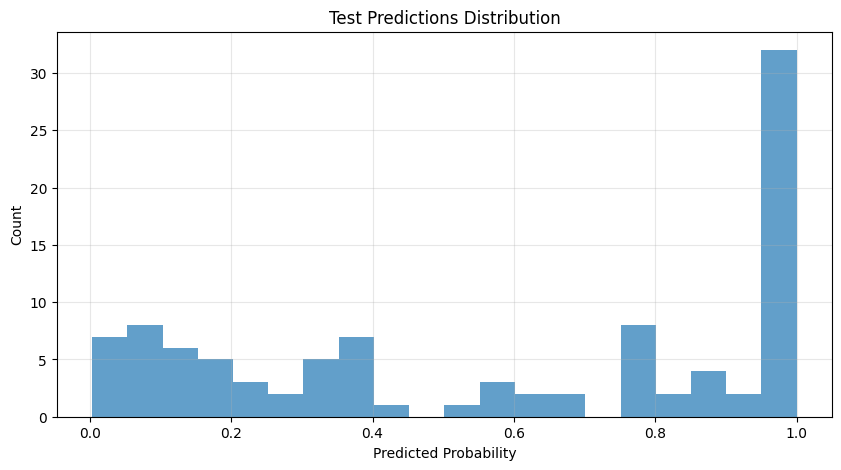

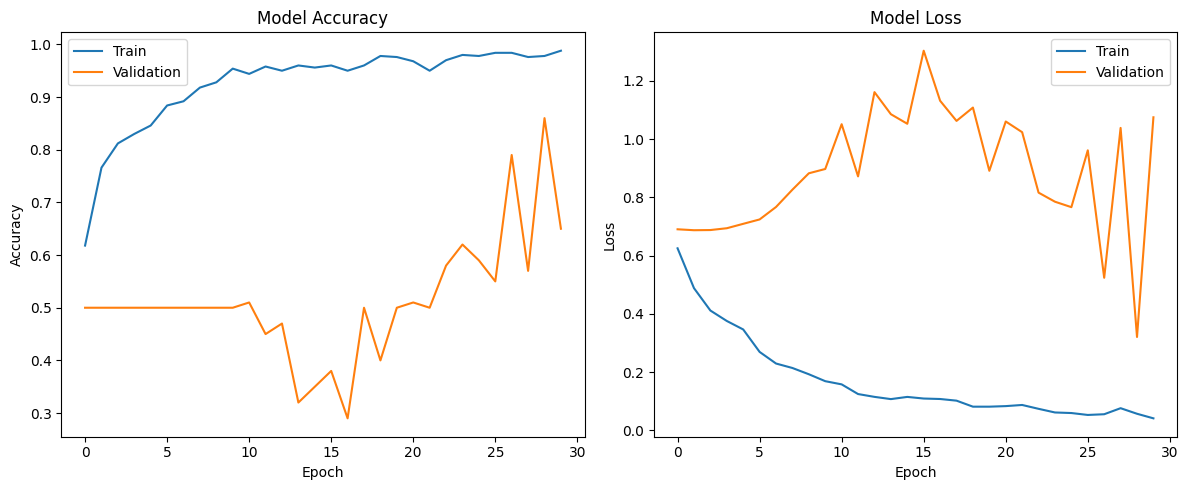

In [47]:
plt.figure(figsize=(10, 5)) 
plt.hist(test_probs, bins=20, alpha=0.7) 
plt.title('Test Predictions Distribution') 
plt.xlabel('Predicted Probability') 
plt.ylabel('Count') 
plt.grid(alpha=0.3) 
plt.savefig('test_predictions.png') 
plt.figure(figsize=(12, 5)) 
plt.subplot(1, 2, 1) 
plt.plot(history.history['accuracy'], label='Train') 
plt.plot(history.history['val_accuracy'], label='Validation') 
plt.title('Model Accuracy') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.legend() 
plt.subplot(1, 2, 2) 
plt.plot(history.history['loss'], label='Train') 
plt.plot(history.history['val_loss'], label='Validation') 
plt.title('Model Loss') 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.legend() 
plt.tight_layout() 
plt.savefig('training_history.png')


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step
Accuracy = 0.84
Precision = 0.8405448717948718
Recall = 0.84
F-Score = 0.8399359743897559


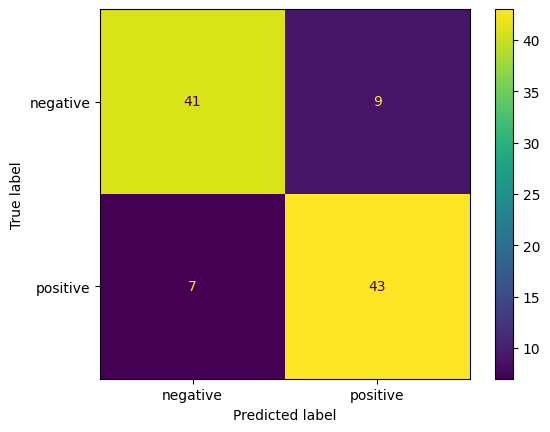

In [48]:
from sklearn import metrics

test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = test_generator.classes
y_pred = y_pred.flatten()
class_names = list(test_generator.class_indices.keys())

cm = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)

print(f"Accuracy = {metrics.accuracy_score(y_true, y_pred)}")
print(f"Precision = {metrics.precision_score(y_true, y_pred, average='weighted')}")
print(f"Recall = {metrics.recall_score(y_true, y_pred, average='weighted')}")
print(f"F-Score = {metrics.f1_score(y_true, y_pred, average='weighted')}")

cm_display.plot()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


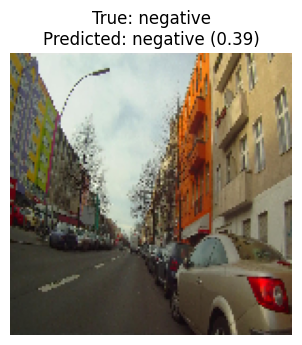

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


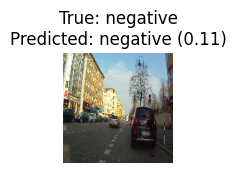

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


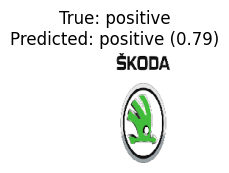

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


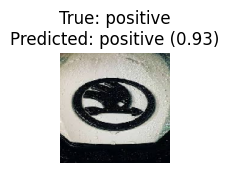

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


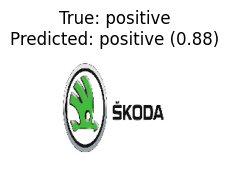

In [49]:
import random 

num_samples = 5 
class_names = list(train_generator.class_indices.keys()) 

num_test_samples = len(test_generator.labels) 
random_indices = random.sample(range(num_test_samples), num_samples) 

plt.figure(figsize=(15, 10)) 
for i, index in enumerate(random_indices): 
    image = test_generator.filepaths[index] 
    true_label = test_generator.labels[index] 
    
    img = tf.keras.utils.load_img(image, target_size=model.input_shape[1:3])  
    img_array = tf.keras.utils.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0) / 255.0 
    
    predictions = model.predict(img_array) 
    probabilities = tf.nn.sigmoid(predictions).numpy().flatten()  
    predicted_class = 1 if probabilities[0] > 0.5 else 0 
    predicted_label = class_names[predicted_class] 
    true_label_name = class_names[true_label] 
    
    plt.subplot(1, num_samples, i + 1) 
    plt.imshow(img) 
    plt.title(f"True: {true_label_name}\nPredicted: {predicted_label} ({probabilities[0]:.2f})") 
    plt.axis('off') 
    plt.tight_layout() 
    plt.show()


In [50]:
import datetime 

now = datetime.datetime.now() 
timestamp = now.strftime("%Y%m%d_%H%M%S") 
file_name = f'xception_{timestamp}.keras' 
model_save_path = file_name 
model.save(model_save_path) 
print(f"Модель успішно збережено за шляхом: {model_save_path}") 

Модель успішно збережено за шляхом: xception_20251119_141953.keras


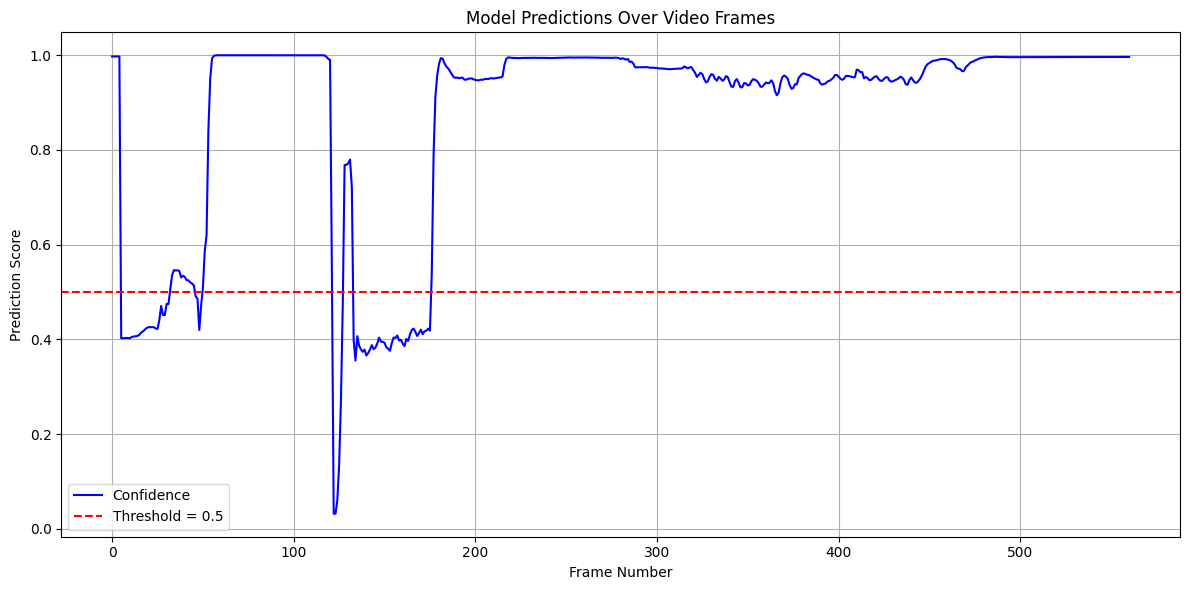

In [51]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.keras.models import load_model 
from tensorflow.keras.applications.inception_v3 import preprocess_input 

video_path = "/kaggle/input/logotypes/logos/logo.mp4" 
cap = cv2.VideoCapture(video_path) 

batch_size = 32 
frames = [] 
frames_ids = [] 
frame_predictions = [] 
frame_numbers = []

frame_count = 0 

def process_batch(batch_frames, batch_ids): 
    batch_np = np.array(batch_frames).astype(np.float32) 
    batch_np = batch_np / 255.0 
    predictions = model.predict(batch_np, verbose=0) 
    for i in range(len(predictions)): 
        score = 1 / (1 + np.exp(-predictions[i][0])) 
        frame_predictions.append(score) 
        frame_numbers.append(batch_ids[i]) 
        
while True: 
    ret, frame = cap.read() 
    if not ret: 
        break 
    
    resized_frame = cv2.resize(frame, (150, 150)) 
    frames.append(resized_frame) 
    frames_ids.append(frame_count) 
    frame_count += 1
    
    if len(frames) == batch_size: 
        process_batch(frames, frames_ids) 
        frames = [] 
        frames_ids = [] 
    
if frames: 
    process_batch(frames, frames_ids) 

cap.release() 

plt.figure(figsize=(12, 6)) 
plt.plot(frame_numbers, frame_predictions, label='Confidence', color='blue') 
plt.axhline(0.5, color='red', linestyle='--', label='Threshold = 0.5') 
plt.xlabel('Frame Number') 
plt.ylabel('Prediction Score') 
plt.title('Model Predictions Over Video Frames') 
plt.legend() 
plt.grid(True) 
plt.tight_layout() 
plt.show() 